# Лабораторная работа № 2. 
## Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

### Цель работы: научиться обрабатывать пропуски в данных для числовых и категориальных признаков, масштабировать данные и преобразовывать категориальные признаки в числовые.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

### Загрузка и первичный анализ данных

Будем использовать данные о звонках в службу экстренной помощи (911) в округе Монтгомери, штат Пенсильвания - https://www.kaggle.com/mchirico/montcoalert

In [2]:
data = pd.read_csv('911.csv', sep=",")

In [3]:
# Размер набора данных
data.shape

(663522, 9)

In [5]:
# Типы колонок
data.dtypes

lat          float64
lng          float64
desc          object
zip          float64
title         object
timeStamp     object
twp           object
addr          object
e              int64
dtype: object

In [6]:
# Проверим есть ли пропущенные значения
data.isnull().sum()

lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
e                0
dtype: int64

In [7]:
# Первые 5 строк датасета
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [8]:
total_count = data.shape[0]
print("Всего строк: {}".format(total_count))

Всего строк: 663522


### Обработка пропусков в данных

Не будем удалять колонки или строки, т.к. в признаке zip пропущено 12% данных, что входит в пределы допустимого.

In [9]:
num_cols =[]
for col in data.columns:
    count_null = data[data[col].isnull()].shape[0] # кол-во пустых значений
    dt = str(data[col].dtypes)
    if count_null>0 and ((dt == 'int64') or (dt == 'float64')):
        num_cols.append(col)
        perc_of_missing = round(count_null/total_count * 100, 2)
        print("Колонка: {}. Тип данных: {}. Количество пустых значений: {}, {}%".format(col, dt, count_null, perc_of_missing))

Колонка: zip. Тип данных: float64. Количество пустых значений: 80199, 12.09%


In [10]:
num_data = data[num_cols]
num_data

,zip
0,19525.0
1,19446.0
2,19401.0
3,19401.0
4,NaN
...,...
663517,19403.0
663518,19403.0
663519,19041.0
663520,19401.0


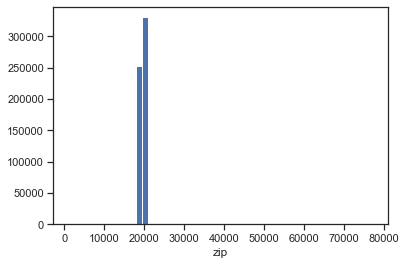

In [28]:
# Гистограмма по признакам
for col in num_data:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [15]:
num_data_zip = num_data['zip']
num_data_zip.head()

0    19525.0
1    19446.0
2    19401.0
3    19401.0
4        NaN
Name: zip, dtype: float64

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [19]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
num_data_zip = num_data_zip.values.reshape(-1,1)
mask_missing_values_only = indicator.fit_transform(num_data_zip)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [20]:
strategies=['mean', 'median', 'most_frequent']

In [21]:
def test_num_impute(strat):
    imp_num = SimpleImputer(strategy = strat)
    data_imp_num = imp_num.fit_transform(num_data_zip)
    return data_imp_num[mask_missing_values_only]

In [22]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([19236.0557907, 19236.0557907, 19236.0557907, ..., 19236.0557907,
        19236.0557907, 19236.0557907]))

In [23]:
strategies[1], test_num_impute(strategies[1])

('median', array([19401., 19401., 19401., ..., 19401., 19401., 19401.]))

In [24]:
strategies[2], test_num_impute(strategies[2])

('most_frequent', array([19401., 19401., 19401., ..., 19401., 19401., 19401.]))

In [30]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strat):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strat)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strat, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [31]:
test_num_impute_col(data, 'zip', strategies[0])

('zip', 'mean', 80199, 19236.05579070258, 19236.05579070258)

In [32]:
test_num_impute_col(data, 'zip', strategies[1])

('zip', 'median', 80199, 19401.0, 19401.0)

In [34]:
test_num_impute_col(data, 'zip', strategies[2])

('zip', 'most_frequent', 80199, 19401.0, 19401.0)

### Обработка пропусков в категориальных данных

In [36]:
num_cols =[]
for col in data.columns:
    count_null = data[data[col].isnull()].shape[0] # кол-во пустых значений
    dt = str(data[col].dtypes)
    if count_null>0 and dt == 'object':
        num_cols.append(col)
        perc_of_missing = round(count_null/total_count * 100, 2)
        print("Колонка: {}. Тип данных: {}. Количество пустых значений: {}, {}%".format(col, dt, count_null, perc_of_missing))

Колонка: twp. Тип данных: object. Количество пустых значений: 293, 0.04%


Процент пропусков мал, поэтому не будем удалять эту колонку.

In [37]:
cat_temp_data = data[['twp']]
cat_temp_data.head()

,twp
0,NEW HANOVER
1,HATFIELD TOWNSHIP
2,NORRISTOWN
3,NORRISTOWN
4,LOWER POTTSGROVE


In [38]:
cat_temp_data['twp'].unique()

array(['NEW HANOVER', 'HATFIELD TOWNSHIP', 'NORRISTOWN',
       'LOWER POTTSGROVE', 'LANSDALE', 'HORSHAM', 'SKIPPACK',
       'LOWER SALFORD', 'PLYMOUTH', 'MONTGOMERY', 'UPPER MORELAND',
       'CHELTENHAM', 'UPPER MERION', 'WHITEMARSH', 'UPPER GWYNEDD',
       'LOWER PROVIDENCE', 'UPPER DUBLIN', 'WHITPAIN', 'DELAWARE COUNTY',
       'FRANCONIA', 'WEST CONSHOHOCKEN', 'LOWER MERION', 'LIMERICK',
       'TOWAMENCIN', 'DOUGLASS', 'POTTSTOWN', 'BRIDGEPORT', 'AMBLER',
       'CHESTER COUNTY', 'UPPER HANOVER', 'SPRINGFIELD', 'ROCKLEDGE',
       'ABINGTON', 'WEST NORRITON', 'ROYERSFORD', 'UPPER SALFORD',
       'LOWER MORELAND', 'CONSHOHOCKEN', 'PENNSBURG', 'TELFORD',
       'EAST NORRITON', 'UPPER FREDERICK', 'UPPER PROVIDENCE', 'SALFORD',
       'HATFIELD BORO', 'LEHIGH COUNTY', 'LOWER GWYNEDD', 'MARLBOROUGH',
       'BRYN ATHYN', 'HATBORO', 'WORCESTER', 'COLLEGEVILLE',
       'SCHWENKSVILLE', 'PERKIOMEN', 'SOUDERTON', 'UPPER POTTSGROVE',
       'LOWER FREDERICK', 'BUCKS COUNTY', 'RED HILL'

In [39]:
cat_temp_data[cat_temp_data['twp'].isnull()].shape

(293, 1)

In [40]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['NEW HANOVER'],
       ['HATFIELD TOWNSHIP'],
       ['NORRISTOWN'],
       ...,
       ['LOWER MERION'],
       ['NORRISTOWN'],
       ['LOWER MERION']], dtype=object)

### Преобразование категориальных признаков в числовые

In [41]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,NEW HANOVER
1,HATFIELD TOWNSHIP
2,NORRISTOWN
3,NORRISTOWN
4,LOWER POTTSGROVE
...,...
663517,EAST NORRITON
663518,LOWER PROVIDENCE
663519,LOWER MERION
663520,NORRISTOWN


#### Label encoding

In [64]:
from sklearn.preprocessing import LabelEncoder

In [65]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [66]:
# Список имеющихся уникальных значений
cat_enc['c1'].unique()

array(['NEW HANOVER', 'HATFIELD TOWNSHIP', 'NORRISTOWN',
       'LOWER POTTSGROVE', 'LANSDALE', 'HORSHAM', 'SKIPPACK',
       'LOWER SALFORD', 'PLYMOUTH', 'MONTGOMERY', 'UPPER MORELAND',
       'CHELTENHAM', 'UPPER MERION', 'WHITEMARSH', 'UPPER GWYNEDD',
       'LOWER PROVIDENCE', 'UPPER DUBLIN', 'WHITPAIN', 'DELAWARE COUNTY',
       'FRANCONIA', 'WEST CONSHOHOCKEN', 'LOWER MERION', 'LIMERICK',
       'TOWAMENCIN', 'DOUGLASS', 'POTTSTOWN', 'BRIDGEPORT', 'AMBLER',
       'CHESTER COUNTY', 'UPPER HANOVER', 'SPRINGFIELD', 'ROCKLEDGE',
       'ABINGTON', 'WEST NORRITON', 'ROYERSFORD', 'UPPER SALFORD',
       'LOWER MORELAND', 'CONSHOHOCKEN', 'PENNSBURG', 'TELFORD',
       'EAST NORRITON', 'UPPER FREDERICK', 'UPPER PROVIDENCE', 'SALFORD',
       'HATFIELD BORO', 'LEHIGH COUNTY', 'LOWER GWYNEDD', 'MARLBOROUGH',
       'BRYN ATHYN', 'HATBORO', 'WORCESTER', 'COLLEGEVILLE',
       'SCHWENKSVILLE', 'PERKIOMEN', 'SOUDERTON', 'UPPER POTTSGROVE',
       'LOWER FREDERICK', 'BUCKS COUNTY', 'RED HILL'

In [67]:
np.unique(cat_enc_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

Чтобы не было фиктивной привязки к отношению порядка, будем использовать one-hot encoding

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [45]:
cat_enc.shape

(663522, 1)

In [46]:
cat_enc_ohe.shape

(663522, 68)

In [47]:
cat_enc_ohe.todense()[0:10] # разреженная матрица

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [52]:
# Быстрый способ one-hot кодирования
pd.get_dummies(cat_enc).head(13) # нет фиктивного отношения порядка, 0 - отсутствие, 1 - наличие значения

,c1_ABINGTON,c1_AMBLER,c1_BERKS COUNTY,c1_BRIDGEPORT,c1_BRYN ATHYN,c1_BUCKS COUNTY,c1_CHELTENHAM,c1_CHESTER COUNTY,c1_COLLEGEVILLE,c1_CONSHOHOCKEN,...,c1_UPPER MORELAND,c1_UPPER POTTSGROVE,c1_UPPER PROVIDENCE,c1_UPPER SALFORD,c1_WEST CONSHOHOCKEN,c1_WEST NORRITON,c1_WEST POTTSGROVE,c1_WHITEMARSH,c1_WHITPAIN,c1_WORCESTER
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Minmax масштабирование

Данные масштабируются в диапазон от 0 до 1

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [55]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['lat']])

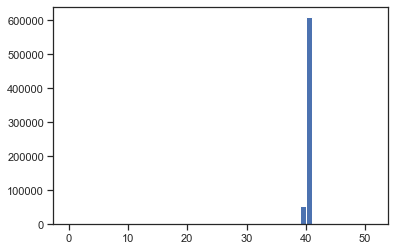

In [58]:
plt.hist(data['lat'], 50)
plt.show()

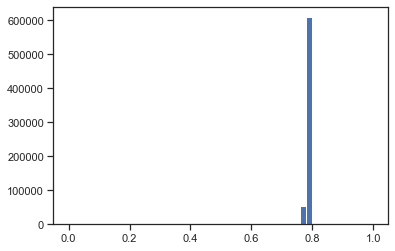

In [59]:
plt.hist(sc1_data, 50)
plt.show()

### Масштабирование данных на основе Z-оценки

Значения распределяются в диапазоне от -3 до 3

In [62]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['lat']])

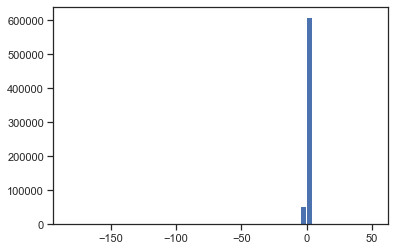

In [63]:
plt.hist(sc2_data, 50)
plt.show()